Treniranje neuralnih mreža se odvija u 2 koraka:

***Forward Propagation***: Mreža daje najbolju pretpostavku o ispravnom izlazu procesirajući ulazne podatke.

***Backward Propagation***: Neuralna mreža vrši prilagođavanje svojih parametara proporcionalno grešci koja je nastala prilikom procene, uzimajući u proračun gradijente unazad od izlaza  mreže. Optimizacija se vrši pomoću *gradient descent* algoritma. 

torch.autograd predstavlja biblioteku PyTorch-a za automatski proračun gradijenata.

**Zadatak 2**: Uraditi Zadatak 1 korišćenjem autograd biblioteke.

In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
# requires_grad=True argument daje naredbu PyTorchu da prati čitavo stablo tenzora koji su rezultat operacija nad parametrima

In [6]:
params.grad is None
# Svi PyTorch tenzori imaju atribut koji se zove grad. Njegova vrednost je obično None

True

Prilikom proračuna funkcije cene dok parametri w i b zahtevaju gradijente, PyTorch kreira i autograd graf u kome su operacije zapisane kao čvorovi (crni krugovi na ilustraciji u nastavku). Kada pozovemo loss.backward(), PyTorch prelazi ovaj graf u obrnutom smeru da bi izračunao gradijente, kao što je prikazano pomoću strelica na sledećoj ilustraciji. 

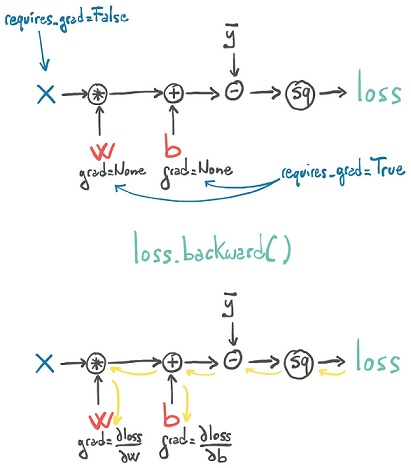

In [7]:
''' All we have to do to populate it is to start with a tensor with requires_grad set to 
True, then call the model and compute the loss, and then call backward on the loss
tensor
'''
loss = loss_fn(model(t_u, *params), t_c)
loss.backward() # Backward computes the sum of gradients of given tensors with respect to graph leaves.

params.grad # Grad computes and returns the sum of gradients of outputs with respect to the inputs.



tensor([4517.2969,   82.6000])

Pozivanje naredbe backward vodi do akumulacije gradijenata u čvorovima lista. Stoga, neophodno je eksplicitno izjednačiti vrednosti gradijenata s nulom nakon ažuriranja parametara.

In [8]:
if params.grad is not None:
    params.grad.zero_()

In [9]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1> This could be done at any point in the loop prior to calling loss.backward().
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # <2> thread local; Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [11]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


In [12]:
print(params)

tensor([  5.3671, -17.3012], requires_grad=True)


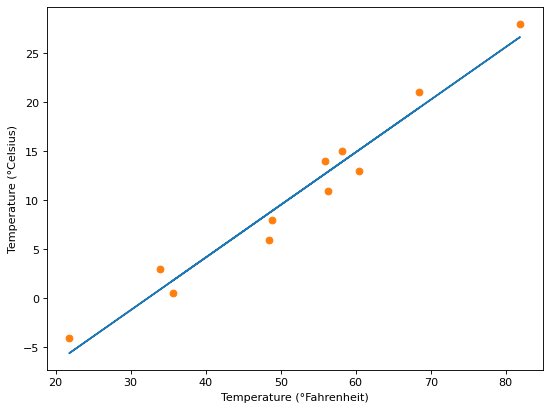

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(figsize=(8,6), dpi=80)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")

# Tensor.detach() returns a new Tensor, detached from the current graph. The result will never require gradient.